# Analyse des Films et Recommandations avec PySpark

Dans ce notebook, nous allons explorer un ensemble de données de films et de notes de spectateurs, puis créer un système de recommandations en utilisant la bibliothèque PySpark. Nous utiliserons diverses fonctionnalités de Spark, comme les transformations de données, les calculs statistiques, ainsi que la réduction de dimension et la standardisation des données.

## Importation des bibliothèques et configuration de l'environnement
Nous commençons par importer les bibliothèques nécessaires et configurer la session Spark.

In [125]:
import sys
try:
    import distutils
except ModuleNotFoundError:
    import setuptools._distutils as distutils
    sys.modules["distutils"] = distutils

Cette partie du script gère l'importation des bibliothèques nécessaires et traite un problème potentiel de module manquant (distutils). Si le module distutils n'est pas disponible, il essaie d'importer setuptools._distutils et le remplace dans le module système.

## Initialisation de la session Spark
Nous initialisons une session Spark avec 4 Go de mémoire allouée pour le driver et les exécutants.

In [126]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count
from pyspark.sql.functions import explode, split

spark = SparkSession.builder \
    .appName("MovieRecommendation") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.python.worker.timeout", "120s") \
    .getOrCreate()

## Chargement des données
Nous chargeons les fichiers CSV contenant les informations des films et des notes.

In [127]:
movies = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)
ratings = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)
movies.show(10)
ratings.show(10)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|

Nous chargeons les fichiers CSV contenant les informations des films et des notes. header=True indique que la première ligne des fichiers CSV contient les en-têtes de colonne, et inferSchema=True permet à Spark de deviner automatiquement les types de données des colonnes. Les fonctions show(10) affichent les 10 premières lignes des DataFrames movies et ratings.

## Exploration des données
Affichage des schémas des deux ensembles de données pour mieux comprendre leur structure. Puis nous examinons le nombre total de film, les notes des films et le nombre d'utilisateurs uniques.

In [128]:
movies.printSchema()
ratings.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [129]:
print(f"Nombre total de films : {movies.count()}")
print(f"Nombre total de notes : {ratings.count()}")

Nombre total de films : 9742
Nombre total de notes : 100836


In [130]:
print(f"Nombre d'utilisateurs uniques : {ratings.select('userId').distinct().count()}")
print(f"Nombre de films notés : {ratings.select('movieId').distinct().count()}")

Nombre d'utilisateurs uniques : 610
Nombre de films notés : 9724


Cette étape affiche les schémas des deux ensembles de données pour mieux comprendre leur structure. Ensuite, nous comptons le nombre total de films, le nombre total de notes, le nombre d'utilisateurs uniques et le nombre de films notés.

## Statistiques descriptives


Affichage du nombre de notation par films.

In [131]:
ratings_count = ratings.groupBy("movieId").agg(count("rating").alias("ratings_count"))
ratings_count.show()

+-------+-------------+
|movieId|ratings_count|
+-------+-------------+
|   1580|          165|
|   2366|           25|
|   3175|           75|
|   1088|           42|
|  32460|            4|
|  44022|           23|
|  96488|            4|
|   1238|            9|
|   1342|           11|
|   1591|           26|
|   1645|           51|
|   4519|            9|
|   2142|           10|
|    471|           40|
|   3997|           12|
|    833|            6|
|   3918|            9|
|   7982|            4|
|   1959|           15|
|  68135|           10|
+-------+-------------+
only showing top 20 rows



Affichage de la répartition des notes données par les utilisateurs.

In [132]:
ratings.describe("rating").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            100836|
|   mean| 3.501556983616962|
| stddev|1.0425292390606342|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



In [133]:
from pyspark.sql.functions import col
ratings.groupBy("rating").count().orderBy(col("rating")).show()

+------+-----+
|rating|count|
+------+-----+
|   0.5| 1370|
|   1.0| 2811|
|   1.5| 1791|
|   2.0| 7551|
|   2.5| 5550|
|   3.0|20047|
|   3.5|13136|
|   4.0|26818|
|   4.5| 8551|
|   5.0|13211|
+------+-----+



In [134]:
best_movies = ratings.groupBy("movieId") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("count_rating")) \
    .filter("count_rating >= 10") \
    .orderBy(col("avg_rating").desc())
best_movies.show(10)

+-------+-----------------+------------+
|movieId|       avg_rating|count_rating|
+-------+-----------------+------------+
|   1041|4.590909090909091|          11|
|   3451|4.545454545454546|          11|
|   1178|4.541666666666667|          12|
|   1104|            4.475|          20|
|   2360|4.458333333333333|          12|
|   1217|4.433333333333334|          15|
|    318|4.429022082018927|         317|
|    951|4.392857142857143|          14|
|   1927|             4.35|          10|
|    922|4.333333333333333|          27|
+-------+-----------------+------------+
only showing top 10 rows



In [135]:
avg_ratings_per_movie = ratings.groupBy("movieId").count().agg({"count": "avg"})
avg_ratings_per_movie.show()

+------------------+
|        avg(count)|
+------------------+
|10.369806663924312|
+------------------+



In [136]:
movies_genres = movies.withColumn("genre", explode(split(col("genres"), "\\|")))
movies_genres.groupBy("genre").count().orderBy(col("count").desc()).show()


+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama| 4361|
|            Comedy| 3756|
|          Thriller| 1894|
|            Action| 1828|
|           Romance| 1596|
|         Adventure| 1263|
|             Crime| 1199|
|            Sci-Fi|  980|
|            Horror|  978|
|           Fantasy|  779|
|          Children|  664|
|         Animation|  611|
|           Mystery|  573|
|       Documentary|  440|
|               War|  382|
|           Musical|  334|
|           Western|  167|
|              IMAX|  158|
|         Film-Noir|   87|
|(no genres listed)|   34|
+------------------+-----+



Dans cette étape, nous affichons la répartition des notes données par les utilisateurs. Nous utilisons groupBy pour regrouper les notes par valeurs uniques et les compter. Ensuite, nous affichons les films les mieux notés en calculant la note moyenne (avg_rating) et le nombre de notes (count_rating) pour chaque film. Nous filtrons pour inclure uniquement les films avec au moins 10 notes. Nous calculons également la moyenne des évaluations par film et explorons les genres de films en décomposant les genres multiples en lignes distinctes (explode et split).

In [137]:
movies=movies.na.drop()
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [138]:
ratings=ratings.na.drop()
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [139]:
movies_r=movies.join(ratings,on="movieId",how="inner")
movies_r.show()

+-------+--------------------+--------------------+------+------+---------+
|movieId|               title|              genres|userId|rating|timestamp|
+-------+--------------------+--------------------+------+------+---------+
|      1|    Toy Story (1995)|Adventure|Animati...|     1|   4.0|964982703|
|      3|Grumpier Old Men ...|      Comedy|Romance|     1|   4.0|964981247|
|      6|         Heat (1995)|Action|Crime|Thri...|     1|   4.0|964982224|
|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   5.0|964983815|
|     50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   5.0|964982931|
|     70|From Dusk Till Da...|Action|Comedy|Hor...|     1|   3.0|964982400|
|    101|Bottle Rocket (1996)|Adventure|Comedy|...|     1|   5.0|964980868|
|    110|   Braveheart (1995)|    Action|Drama|War|     1|   4.0|964982176|
|    151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   5.0|964984041|
|    157|Canadian Bacon (1...|          Comedy|War|     1|   5.0|964984100|
|    163|   

Nous supprimons les valeurs nulles dans les deux ensembles de données (na.drop()). Ensuite, nous effectuons une jointure interne (inner join) des données de films et des évaluations sur la colonne movieId.

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Visualisation des données

### Convertion du dataframe Spark des ratings et création de l'histogramme de répartion des notes

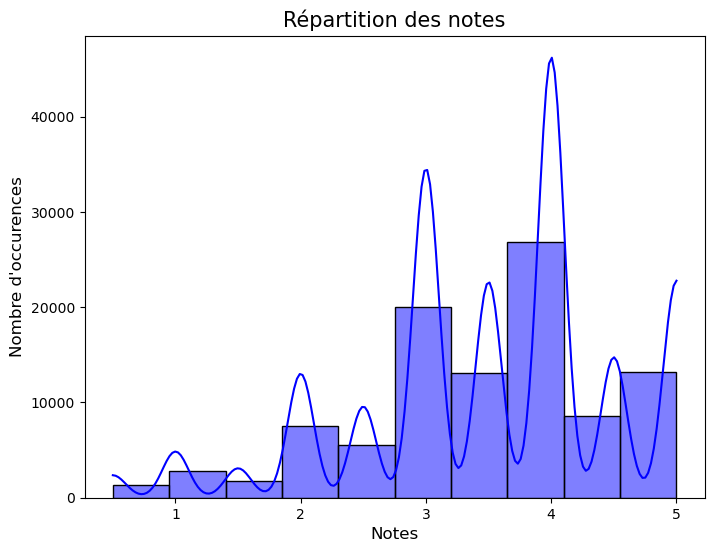

In [141]:

ratings_pd = ratings.select("rating").toPandas()

plt.figure(figsize=(8, 6))
sns.histplot(ratings_pd['rating'], bins=10, kde=True, color='blue')
plt.title("Répartition des notes", fontsize=15)
plt.xlabel("Notes", fontsize=12)
plt.ylabel("Nombre d'occurences", fontsize=12)
plt.show()


### Genres les plus populaires

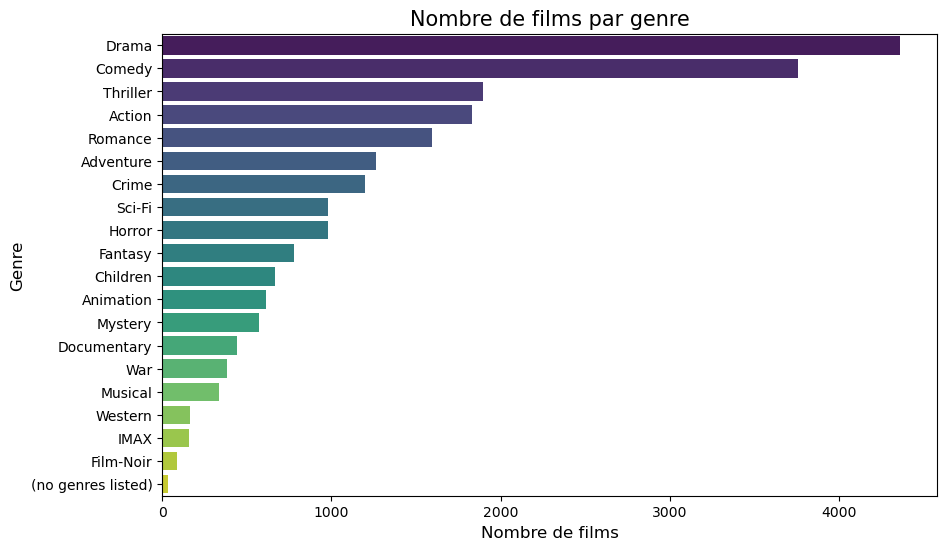

In [142]:
movies_genres_pd = movies_genres.groupBy("genre").count().orderBy(col("count").desc()).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=movies_genres_pd, x="count", y="genre", palette="viridis")
plt.title("Nombre de films par genre", fontsize=15)
plt.xlabel("Nombre de films", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.show()


### Top 10 des films les plus notés

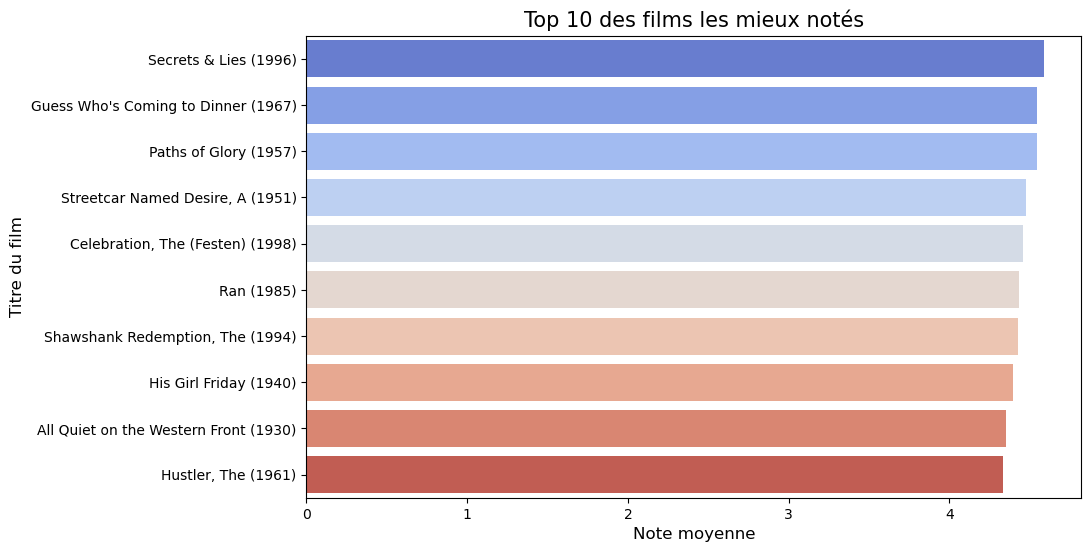

In [143]:
best_movies_pd = best_movies.join(movies, on="movieId").select("title", "avg_rating").orderBy(col("avg_rating").desc()).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=best_movies_pd, x="avg_rating", y="title", palette="coolwarm")
plt.title("Top 10 des films les mieux notés", fontsize=15)
plt.xlabel("Note moyenne", fontsize=12)
plt.ylabel("Titre du film", fontsize=12)
plt.show()


## Modèle de recommandation avec ALS

### Entraînement du modèle ALS

In [144]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

Nous utilisons l'algorithme ALS (Alternating Least Squares) pour créer un modèle de recommandation. ALS se base uniquement sur les notes attribuées par les utilisateurs.

Nous divisons les données en un ensemble d'entraînement et un ensemble de test, entraînons le modèle, et faisons des prédictions.

In [145]:
x_train,x_test= movies_r.randomSplit([0.8,0.2])
als=ALS(maxIter=10, 
        regParam=0.1,
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        coldStartStrategy="drop",
        rank=10)

Nous divisons les données en ensembles d'entraînement (x_train) et de test (x_test) avec une répartition de 80% pour l'entraînement et 20% pour le test.

Nous utilisons l'algorithme ALS pour entraîner un modèle de recommandation. Pour gérer les valeurs manquantes, nous appliquons l'hyperparamètre coldStartStrategy="drop", qui supprime les prédictions lorsque ALS ne dispose pas d'assez d'informations pour généraliser correctement.

Afin d'optimiser la performance du modèle, nous testons plusieurs valeurs pour les hyperparamètres suivants :

- maxIter = 10 : Un nombre d'itérations suffisant pour assurer la convergence du modèle sans risquer de surajustement.
- regParam = 0.1 : Une régularisation plus forte qui prévient le surajustement en limitant les valeurs extrêmes.
- rank = 10 : Un nombre optimal de facteurs latents permettant de mieux capturer les relations complexes entre les films et les préférences des utilisateurs.
Le modèle est ensuite ajusté (fit) sur les données d'entraînement et évalué sur l'ensemble de test. 

Nous générons des recommandations pour tous les utilisateurs et tous les films, et nous les affichons.


In [146]:
model_als=als.fit(x_train)
pred=model_als.transform(x_test)
pred.show()

+-------+--------------------+--------------------+------+------+----------+----------+
|movieId|               title|              genres|userId|rating| timestamp|prediction|
+-------+--------------------+--------------------+------+------+----------+----------+
|    527|Schindler's List ...|           Drama|War|   463|   4.0|1145460304| 3.5103657|
|    552|Three Musketeers,...|Action|Adventure|...|   463|   3.5|1145459400| 3.1223931|
|    858|Godfather, The (1...|         Crime|Drama|   496|   5.0|1415166629| 4.0906386|
|   1221|Godfather: Part I...|         Crime|Drama|   463|   4.5|1145460455| 3.9867713|
|   3668|Romeo and Juliet ...|       Drama|Romance|   496|   3.0|1415165655| 3.0145547|
|   3753| Patriot, The (2000)|    Action|Drama|War|   463|   4.0|1145460023| 3.8668902|
|   4306|        Shrek (2001)|Adventure|Animati...|   496|   3.0|1415520455| 3.1411948|
|   4308| Moulin Rouge (2001)|Drama|Musical|Rom...|   148|   4.0|1482548613| 3.5011911|
|   5816|Harry Potter and ...|  

### Evaluation du modèle

#### RMSE

In [147]:
eval=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
rmse = eval.evaluate(pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.8860918933324715


Le Root Mean Squared Error (RMSE) indique que l'erreur moyenne des prédictions du modèle est d'environ 0.88 points par rapport aux notes réelles, sur une échelle de 0 à 5.  Un RMSE inférieur à 1 montre que le modèle est capable de faire des prédictions très proches des évaluations réelles des utilisateurs.


#### MAE

In [148]:
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = mae_evaluator.evaluate(pred)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.6808265310561792


Plus la MAE est faible, plus le modèle est précis.
Une MAE de 0.68 signifie que, en moyenne, la prédiction de notre modèle ALS est décalée de 0.68 points par rapport à la note réelle attribuée par l’utilisateur.
Une MAE entre 0,5 et 1 est un résultat correct, tandis qu'une MAE < 0,5 est considéré comme très bon. 

### Test de l'ALS avec filtre sur les films peu notés

Après avoir entraîner et evaluer le modèle ALS, je souhaite tester l'impact d'un filtre qui exclut les films qui n'ont pas été beaucoup notés. 
Les films avec peu de notes peuvent fausser les recommandations, car ils ne reflètent pas vraiment les préférences des utilisateurs. En filtrant ces films, on vise à améliorer la qualité et la pertinence des recommandations.


#### Processus

- Calculer les notations : compter le nombre de notes par film
- Définir un seuil (10 dans norre cas qui veut dire que l'on recupère que les films qui ont été notés au moins 10 fois)
- Filtrer les films : on élimine les films qui n'atteignent pas ce seuil
- Application de l'ALS : réentraînement du modèle ALS avec les données filtrés
- Évaluer les performances : avec le RMSE et le MAE

In [149]:
threshold = 10
popular_movies = ratings_count.filter(ratings_count.ratings_count >= threshold)
movies_r_filter = movies_r.join(popular_movies, on="movieId", how="inner")
movies_r_filter.show()

+-------+--------------------+--------------------+------+------+---------+-------------+
|movieId|               title|              genres|userId|rating|timestamp|ratings_count|
+-------+--------------------+--------------------+------+------+---------+-------------+
|      1|    Toy Story (1995)|Adventure|Animati...|     1|   4.0|964982703|          215|
|      3|Grumpier Old Men ...|      Comedy|Romance|     1|   4.0|964981247|           52|
|      6|         Heat (1995)|Action|Crime|Thri...|     1|   4.0|964982224|          102|
|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   5.0|964983815|          203|
|     50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   5.0|964982931|          204|
|     70|From Dusk Till Da...|Action|Comedy|Hor...|     1|   3.0|964982400|           55|
|    101|Bottle Rocket (1996)|Adventure|Comedy|...|     1|   5.0|964980868|           23|
|    110|   Braveheart (1995)|    Action|Drama|War|     1|   4.0|964982176|          237|
|    151| 

In [ ]:
x_train, x_test = movies_r_filter.randomSplit([0.8, 0.2])

als2 = ALS(maxIter=10, 
            regParam=0.1,
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            coldStartStrategy="drop",
            rank=10)

model_als2 = als2.fit(x_train)

pred2 = model_als2.transform(x_test)
pred2.show()


+-------+----------------+--------------------+------+------+----------+-------------+----------+
|movieId|           title|              genres|userId|rating| timestamp|ratings_count|prediction|
+-------+----------------+--------------------+------+------+----------+-------------+----------+
|      1|Toy Story (1995)|Adventure|Animati...|     5|   4.0| 847434962|          215|  4.120083|
|      1|Toy Story (1995)|Adventure|Animati...|     7|   4.5|1106635946|          215| 3.9569266|
|      1|Toy Story (1995)|Adventure|Animati...|    17|   4.5|1305696483|          215| 3.9942489|
|      1|Toy Story (1995)|Adventure|Animati...|    32|   3.0| 856736119|          215|  4.023416|
|      1|Toy Story (1995)|Adventure|Animati...|    40|   5.0| 832058959|          215| 3.9645314|
|      1|Toy Story (1995)|Adventure|Animati...|    66|   4.0|1104643957|          215|  4.225182|
|      1|Toy Story (1995)|Adventure|Animati...|    68|   2.5|1158531426|          215| 3.6631193|
|      1|Toy Story (

In [157]:
eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = eval.evaluate(pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")

mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = mae_evaluator.evaluate(pred)
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 0.8384928371422417
Mean Absolute Error (MAE): 0.6478694564471419


#### Impact du filtrage 

Bien que l'amélioration des métriques après le filtrage des films peu notés soit positive, la différence entre les résultats avant et après le filtrage n'est pas très marquée.

La réduction du RMSE (de 0.8861 à 0.8385) et du MAE (de 0.6808 à 0.6479) indique une légère amélioration, mais la différence n'est pas énorme. Cela suggère que le modèle est déjà relativement performant même sans filtrage.

En augmentant le seuil de notation, on observe généralement que les métriques d'erreur (RMSE et MAE) ont tendance à diminuer, ce qui indique que le modèle est en mesure de faire de meilleures prédictions sur des films plus populaires.
Cependant, il est essentiel de trouver un équilibre. Si le seuil est trop élevé, cela peut conduire à l'élimination d'un nombre significatif de films, limitant ainsi la diversité des recommandations. Cela pourrait restreindre les options pour les utilisateurs, surtout pour ceux qui ont des goûts variés ou qui recherchent des films moins connus.

Par la suite, nous allons explorer d'autres approches, telles que TF-IDF pour la recommandation basée sur le contenu et KNN (K-Nearest Neighbors) pour la recommandation basée sur les utilisateurs. Ces méthodes complémentaires me permettront d'enrichir les recommandations et d'améliorer encore l'expérience utilisateur.

### Recommandations de films pour tous les utilisateurs 

In [151]:
userRecs = model_als.recommendForAllUsers(5) 
userRecs.show(truncate=False)


+------+----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|1     |[{720, 5.7742825}, {179135, 5.615427}, {138966, 5.615427}, {134796, 5.615427}, {117531, 5.615427}]  |
|2     |[{1274, 4.9150944}, {5075, 4.9082074}, {131724, 4.9063945}, {7842, 4.8153443}, {53123, 4.7677064}]  |
|3     |[{4821, 5.2839694}, {26865, 5.1721997}, {70946, 5.140527}, {3837, 5.0732484}, {6835, 4.927892}]     |
|4     |[{52435, 5.2029424}, {106100, 5.1340976}, {2067, 5.1306005}, {5060, 5.106106}, {1262, 5.054306}]    |
|5     |[{25771, 5.367638}, {7700, 5.074832}, {898, 5.040386}, {7008, 5.0231056}, {132333, 4.9860153}]      |
|6     |[{232, 5.0000515}, {106100, 4.8379645}, {47997, 4.828214}, {5466, 4.7524796}, {104374, 4.7360544}]  |
|7     |[{

### Recommandations de films pour certains utilisateurs 

In [152]:
from pyspark.sql import Row
users = [Row(userId=1), Row(userId=2), Row(userId=3), Row(userId=4), Row(userId=5)]
fake_users_df = spark.createDataFrame(users)
user_recommendations = model_als.recommendForAllUsers(5)
user_recs = user_recommendations.filter(user_recommendations.userId.isin([1, 2, 3, 4, 5]))
user_recs.show(truncate=False)

+------+--------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                   |
+------+--------------------------------------------------------------------------------------------------+
|1     |[{720, 5.7742825}, {179135, 5.615427}, {138966, 5.615427}, {134796, 5.615427}, {117531, 5.615427}]|
|2     |[{1274, 4.9150944}, {5075, 4.9082074}, {131724, 4.9063945}, {7842, 4.8153443}, {53123, 4.7677064}]|
|3     |[{4821, 5.2839694}, {26865, 5.1721997}, {70946, 5.140527}, {3837, 5.0732484}, {6835, 4.927892}]   |
|4     |[{52435, 5.2029424}, {106100, 5.1340976}, {2067, 5.1306005}, {5060, 5.106106}, {1262, 5.054306}]  |
|5     |[{25771, 5.367638}, {7700, 5.074832}, {898, 5.040386}, {7008, 5.0231056}, {132333, 4.9860153}]    |
+------+--------------------------------------------------------------------------------------------------+



Ici, nous pouvons voir les films recommandés pour cinq utilisateurs choisis fictifs (utilisateurs avec userId 1 à 5). Grâce à l'utilisation du modèle de recommandation ALS, nous avons généré des recommandations spécifiques pour ces utilisateurs, même s'ils n'ont pas d'historique d'évaluation dans notre jeu de données.

Les recommandations sont filtrées pour ne montrer que les résultats pertinents pour ces utilisateurs fictifs. Ainsi, le DataFrame affiché nous donne un aperçu des films que le modèle recommande à chacun de ces utilisateurs, en se basant sur les préférences apprises à partir des données d'évaluation disponibles.

## Recommandations avec TF-IDF

In [153]:
from pyspark.sql.functions import explode, split

movies = movies.withColumn("genre", explode(split(movies["genres"], "\\|")))
movies.show(5)


+-------+----------------+--------------------+---------+
|movieId|           title|              genres|    genre|
+-------+----------------+--------------------+---------+
|      1|Toy Story (1995)|Adventure|Animati...|Adventure|
|      1|Toy Story (1995)|Adventure|Animati...|Animation|
|      1|Toy Story (1995)|Adventure|Animati...| Children|
|      1|Toy Story (1995)|Adventure|Animati...|   Comedy|
|      1|Toy Story (1995)|Adventure|Animati...|  Fantasy|
+-------+----------------+--------------------+---------+
only showing top 5 rows



In [154]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Chargement des données
def load_movies(path_csv):
    """
    Charge le fichier CSV des films et retourne un DataFrame.
    """
    return pd.read_csv(path_csv)


# 2. Nettoyage des genres
def prepare_genres(df, original_col="genres", new_col="processed_genres"):
    """
    Transforme la colonne 'genres' en texte utilisable par TF-IDF.
    Par exemple : "Action|Comedy" -> "Action Comedy".
    """
    def format_genre_list(g):
        if isinstance(g, str):
            return " ".join(g.split("|"))
        return ""
    
    df[new_col] = df[original_col].apply(format_genre_list)
    return df


# 3. Calcul de la matrice TF-IDF
def build_tfidf_matrix(df, text_col="processed_genres"):
    """
    Construit la matrice TF-IDF à partir de la colonne textuelle spécifiée.
    Retourne la matrice TF-IDF et l'objet vectorizer (optionnel si besoin).
    """
    vectorizer = TfidfVectorizer()
    tfidf_mat = vectorizer.fit_transform(df[text_col])
    return tfidf_mat, vectorizer


# 4. Matrice de similarité cosinus
def compute_cosine_similarity_matrix(tfidf_mat):
    """
    Calcule la matrice de similarité cosinus à partir de la matrice TF-IDF.
    """
    return cosine_similarity(tfidf_mat, tfidf_mat)


# 5. Mapping titre -> index
def create_title_index_mapping(df, title_col="title"):
    """
    Crée une correspondance (titre du film) -> (index de la ligne).
    """
    return pd.Series(df.index, index=df[title_col]).drop_duplicates()


# 6. Fonction de recommandation
def suggest_similar_movies(movie_title, df, similarity_matrix, title_index_map, top_n=5):
    """
    Propose les films les plus similaires (top_n) au film donné.
    Basé sur la similarité cosinus des genres TF-IDF.
    """
    if movie_title not in title_index_map:
        return [f"Le film '{movie_title}' n'existe pas dans le dataset."]
    
    # Récupérer l'index du film
    film_idx = title_index_map[movie_title]
    
    # Récupérer la liste (index_film, similarité) pour tout le dataset
    sim_scores = list(enumerate(similarity_matrix[film_idx]))
    
    # Trier par similarité décroissante et enlever la première position (le film lui-même)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Extraire les index des films similaires
    neighbors_idx = [x[0] for x in sim_scores]
    
    # Retourner les titres correspondants
    return df.loc[neighbors_idx, "title"].tolist()


# ----- Partie exécution (Notebook) -----

#
movies_df = load_movies("ml-latest-small/movies.csv")

movies_df = prepare_genres(movies_df)

# C. Construire la matrice TF-IDF
tfidf_matrix, _ = build_tfidf_matrix(movies_df, text_col="processed_genres")

# D. Calculer la matrice de similarité
similarity_matrix = compute_cosine_similarity_matrix(tfidf_matrix)

# E. Générer le mapping titre -> index
title_index_map = create_title_index_mapping(movies_df)

# F. Faire un test de recommandation
film_test = "Toy Story (1995)"
suggestions = suggest_similar_movies(
    movie_title=film_test, 
    df=movies_df, 
    similarity_matrix=similarity_matrix, 
    title_index_map=title_index_map, 
    top_n=5
)

print(f"\nFilms similaires à '{film_test}':")
for movie in suggestions:
    print(f" - {movie}")


Films similaires à 'Toy Story (1995)':
 - Antz (1998)
 - Toy Story 2 (1999)
 - Adventures of Rocky and Bullwinkle, The (2000)
 - Emperor's New Groove, The (2000)
 - Monsters, Inc. (2001)


### Evaluation du modèle

### Recommandations de films pour certains utilisateurs 

## Recommandations avec KNN

In [155]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1. Charger les données
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

# -----------------------------------------------------------------------------
# 2. Construire la matrice utilisateur-film
#    (rows = userId, columns = movieId, values = rating)
# -----------------------------------------------------------------------------
user_movie_ratings = ratings.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
)

# Remplacer les NaN par 0 (ou une autre stratégie)
user_movie_ratings.fillna(0, inplace=True)

# -----------------------------------------------------------------------------
# 3. Appliquer l'algorithme KNN pour trouver des utilisateurs similaires
# -----------------------------------------------------------------------------
# On convertit le DataFrame en array NumPy
user_item_matrix = user_movie_ratings.values  # shape: (nb_users, nb_movies)

# Créer le modèle KNN
# metric="cosine" pour se baser sur la similarité cosinus
# algorithm="brute" suffit pour un dataset de petite taille
knn_model = NearestNeighbors(metric="cosine", algorithm="brute")
knn_model.fit(user_item_matrix)

# Mapping pour passer de userId -> index du tableau et inversement
user_ids = user_movie_ratings.index.tolist()              # liste de tous les userId
user_index_map = {uid: idx for idx, uid in enumerate(user_ids)}  # userId -> index

# Inverse pour retrouver l'userId depuis un index
index_user_map = {idx: uid for uid, idx in user_index_map.items()}

# -----------------------------------------------------------------------------
# 4. Fonction de recommandation
# -----------------------------------------------------------------------------
def recommend_movies_for_user(target_user_id, k=5, top_n=5):
    """
    Recommande des films pour l'utilisateur 'target_user_id' en se basant
    sur les notes de ses k plus proches voisins.
    
    k: nombre de voisins (KNN)
    top_n: nombre de recommandations à retourner
    """
    if target_user_id not in user_index_map:
        print(f"L'utilisateur {target_user_id} n'existe pas dans les données.")
        return []
    
    # Récupérer l'index (ligne) correspondant à target_user_id
    user_idx = user_index_map[target_user_id]
    
    # Transformer la ligne en un vecteur (1 x nb_movies)
    user_vector = user_item_matrix[user_idx].reshape(1, -1)
    
    # Trouver les k voisins + 1 (car le plus proche est souvent l'utilisateur lui-même)
    distances, indices = knn_model.kneighbors(user_vector, n_neighbors=k+1)
    
    # indices est une liste de listes
    # La première (et unique) liste contient les indices des k+1 plus proches voisins
    neighbors_indices = indices[0]
    
    # Exclure l'utilisateur lui-même (dont l'indice = user_idx)
    neighbors_indices = [n for n in neighbors_indices if n != user_idx]
    
    # Si la liste est vide après exclusion, on arrête
    if not neighbors_indices:
        print(f"Aucun voisin trouvé pour l'utilisateur {target_user_id}.")
        return []
    
    # Récupérer les notes des voisins
    # shape: (k, nb_movies)
    neighbors_ratings = user_item_matrix[neighbors_indices, :]
    
    # Calculer la moyenne des notes des voisins pour chaque film
    mean_ratings = neighbors_ratings.mean(axis=0)  # shape: (nb_movies,)

    # Récupérer les notes du target_user pour savoir ce qui est déjà vu
    user_ratings = user_item_matrix[user_idx]

    # Construire un DataFrame "predictions" avec la moyenne des ratings
    # pour chaque film, si le user ne l'a pas déjà noté
    predictions_df = pd.DataFrame({
        "movieId": user_movie_ratings.columns,
        "mean_rating": mean_ratings,
        "user_rating": user_ratings
    })
    
    # Filtrer les films déjà notés par l'utilisateur (p. ex. > 0)
    # ou on peut filtrer par (user_rating == 0) si on veut recommander ce qu'il n'a pas vu du tout
    to_recommend_df = predictions_df[predictions_df["user_rating"] == 0]
    
    # Trier par note moyenne décroissante (les films les mieux notés par les voisins)
    to_recommend_df = to_recommend_df.sort_values(by="mean_rating", ascending=False)
    
    # Prendre les top_n
    top_recs = to_recommend_df.head(top_n)
    
    # Ajouter le titre pour être plus lisible (join sur movies)
    # On doit faire attention aux types (movieId du pivot est int, movies["movieId"] aussi)
    top_recs = top_recs.merge(movies[["movieId", "title"]], on="movieId", how="left")
    
    # Retourner la liste des titres (ou le DataFrame complet)
    return top_recs[["movieId", "title", "mean_rating"]].values.tolist()

# -----------------------------------------------------------------------------
# 5. Exemple d'utilisation
# -----------------------------------------------------------------------------
target_user_id = 4
recs = recommend_movies_for_user(target_user_id, k=5, top_n=5)

print(f"Recommandations pour l'utilisateur {target_user_id}:")
for movie_id, title, rating in recs:
    print(f" - {title} (mean_rating={rating:.2f})")


Recommandations pour l'utilisateur 4:
 - Godfather, The (1972) (mean_rating=5.00)
 - Graduate, The (1967) (mean_rating=4.80)
 - Apocalypse Now (1979) (mean_rating=4.80)
 - Reservoir Dogs (1992) (mean_rating=4.60)
 - Clockwork Orange, A (1971) (mean_rating=4.60)


### Evaluation du modèle

### Recommandations de films pour certains utilisateurs 

## Comparaison des approches de recommandations

### Performances des différentes méthodes 

### Comparaison des résultats 

## Conclusion